#Twitter-Bot Detection Dataset

In [ ]:
%pip install --upgrade pip

In [ ]:
%pip install kagglehub pandas matplotlib seaborn tensorflow
%pip install --upgrade tensorflow

In [ ]:
%pip install numpy h5py pyyaml protobuf transformers

In [ ]:
%pip install transformers

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Download latest version
path = kagglehub.dataset_download("goyaladi/twitter-bot-detection-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\usicc\.cache\kagglehub\datasets\goyaladi\twitter-bot-detection-dataset\versions\2


In [16]:
#Изучить набор данных, исследовать на пропуске, выбросы, балансировку по классам и тд

User ID: Уникальный идентификатор пользователя. Можно использовать для отслеживания уникальных пользователей в анализе.
Username: Имя пользователя. Оно может помочь в дополнительной идентификации или в поиске пользователей в Twitter, если это необходимо.
Tweet: Текст твита. Анализ текстового контента может дать возможность выявить паттерны, типичные для ботов (например, повторяющиеся фразы, отсутствие оригинальности в контенте и т.д.).
Retweet Count: Количество ретвитов. Это может помочь в оценке влияния сообщения и оценке активности пользователей.
Mention Count: Количество упоминаний в твите. Может указать на уровень взаимодействия пользователя с другими аккаунтами.
Follower Count: Количество подписчиков пользователя. Боты часто могут иметь высокий или низкий уровень подписчиков в зависимости от их функциональности.
Verified: Булевое значение, показывающее, подтвержден ли аккаунт. Проверенные аккаунты можно считать более надежными.
Bot Label: Метка, указывающая, является ли пользователь ботом или нет. Эта информация будет полезна для машинного обучения, поскольку она позволяет обучать модели на размеченных данных.
Location: Локация пользователя. Это может помочь в географическом анализе и выявлении паттернов использования ботов в определенных регионах.
Created At: Дата и время создания твита. Это может помочь проанализировать временные паттерны и активность пользователей.
Hashtags: Хэштеги в твите. Анализ хэштегов может помочь понять, о чем говорит пользователь и какие темы наиболее популярны.

In [17]:
data = pd.read_csv('bot_detection_data.csv')

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   User ID         50000 non-null  int64 
 1   Username        50000 non-null  object
 2   Tweet           50000 non-null  object
 3   Retweet Count   50000 non-null  int64 
 4   Mention Count   50000 non-null  int64 
 5   Follower Count  50000 non-null  int64 
 6   Verified        50000 non-null  bool  
 7   Bot Label       50000 non-null  int64 
 8   Location        50000 non-null  object
 9   Created At      50000 non-null  object
 10  Hashtags        41659 non-null  object
dtypes: bool(1), int64(5), object(5)
memory usage: 3.9+ MB
None


In [18]:
missing_values = data.isnull().sum()
print("Пропущенные значения:\n", missing_values[missing_values > 0])

data['Hashtags'].fillna('', inplace=True)

Пропущенные значения:
 Hashtags    8341
dtype: int64


C:\Users\usicc\AppData\Local\Temp\ipykernel_5824\3096766028.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Hashtags'].fillna('', inplace=True)


Баланс классов:
 Bot Label
1    25018
0    24982
Name: count, dtype: int64


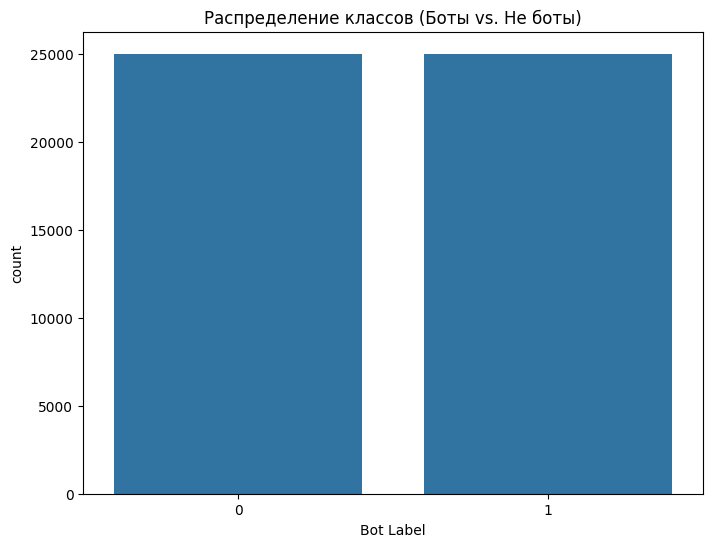

In [19]:
class_counts = data['Bot Label'].value_counts()
print("Баланс классов:\n", class_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='Bot Label', data=data)
plt.title('Распределение классов (Боты vs. Не боты)')
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('bot_detection_data.csv')

df_sample = df.head(100)

df_sample['Verified'] = df_sample['Verified'].astype(int)

label_encoder = LabelEncoder()
df_sample['Username'] = label_encoder.fit_transform(df_sample['Username'])

# Перекодируем Hashtags с использованием TF-IDF
tfidf_vectorizer_hashtags = TfidfVectorizer(max_features=5)
hashtags_tfidf = tfidf_vectorizer_hashtags.fit_transform(df_sample['Hashtags'].fillna('No Hashtags')).toarray()
hashtags_tfidf_df = pd.DataFrame(hashtags_tfidf, columns=tfidf_vectorizer_hashtags.get_feature_names_out())
df_sample = pd.concat([df_sample, hashtags_tfidf_df], axis=1)

# Перекодируем Tweet с использованием TF-IDF
tfidf_vectorizer_tweet = TfidfVectorizer(max_features=5)
tweets_tfidf = tfidf_vectorizer_tweet.fit_transform(df_sample['Tweet']).toarray()
tweets_tfidf_df = pd.DataFrame(tweets_tfidf, columns=tfidf_vectorizer_tweet.get_feature_names_out())
df_sample = pd.concat([df_sample, tweets_tfidf_df], axis=1)

# Преобразуем Created At в datetime и затем в float (timestamp)
df_sample['Created At'] = pd.to_datetime(df_sample['Created At'], errors='coerce').astype(int) / 10**9
df_sample['Created At'] = df_sample['Created At'].fillna(0)

# Перекодируем Location с использованием One-Hot Encoding
df_sample = pd.get_dummies(df_sample, columns=['Location'], drop_first=True)

numeric_df = df_sample.select_dtypes(include=['int64', 'float64', 'bool'])

correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix for Sampled Data')
plt.show()

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

df = pd.read_csv('bot_detection_data.csv')

df_sample = df[['Username', 'Bot Label']].dropna()

df_sample['Bot Label'] = df_sample['Bot Label'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df_sample['Username'], 
    df_sample['Bot Label'], 
    test_size=0.2, 
    random_state=42
)

pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='char', ngram_range=(1, 3))),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train) 

y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

df['Predicted Bot'] = pipeline.predict(df['Username'].fillna(''))

bot_users = df[df['Predicted Bot'] == 1]

Accuracy: 0.5003
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      4968
           1       0.50      0.50      0.50      5032

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



In [6]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertModel
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from tqdm import tqdm

df = pd.read_csv('bot_detection_data.csv')
df = df.sample(n=50000, random_state=42)

df_sample = df[['Username', 'Bot Label']].dropna()
df_sample['Bot Label'] = df_sample['Bot Label'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df_sample['Username'], 
    df_sample['Bot Label'], 
    test_size=0.2, 
    random_state=42
)

pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='char', ngram_range=(1, 3))),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

df['Predicted Bot'] = pipeline.predict(df['Username'].fillna(''))
df['Is Bot'] = df['Predicted Bot']

features = df[['Tweet', 'Verified', 'Retweet Count', 'Mention Count', 'Follower Count']]
labels = df['Bot Label']
train_texts, test_texts, train_labels, test_labels, train_features, test_features = train_test_split(
    features['Tweet'],
    labels,
    features[['Verified', 'Retweet Count', 'Mention Count', 'Follower Count']],
    test_size=0.2,
    random_state=42
)

train_features = train_features.apply(pd.to_numeric, errors='coerce').fillna(0)
test_features = test_features.apply(pd.to_numeric, errors='coerce').fillna(0)

class BertDataset(Dataset):
    def __init__(self, texts, labels, additional_features, tokenizer):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=128)
        self.labels = labels.tolist()
        self.additional_features = additional_features.values.astype(float)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)
        item['additional_features'] = torch.tensor(self.additional_features[idx], dtype=torch.float32)
        return item

    def __len__(self):
        return len(self.labels)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_dataset = BertDataset(train_texts, train_labels, train_features, tokenizer)
test_dataset = BertDataset(test_texts, test_labels, test_features, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

class BertClassifier(nn.Module):
    def __init__(self, additional_features_count):
        super(BertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.linear1 = nn.Linear(self.bert.config.hidden_size + additional_features_count, 64)
        self.linear2 = nn.Linear(64, 1)

    def forward(self, input_ids, attention_mask, additional_features):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[0][:, 0, :]
        pooled_output = self.dropout(pooled_output)
        combined_output = torch.cat((pooled_output, additional_features), dim=1)
        return self.linear2(self.dropout(self.linear1(combined_output)))

In [7]:
epochs = 4
learning_rate = 1e-5

model = BertClassifier(additional_features_count=train_features.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}', unit='batch')
    
    for batch in pbar:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels'].float().unsqueeze(1)
        additional_features = batch['additional_features']
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, additional_features)
        
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        predictions = torch.sigmoid(outputs).round()
        correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

        current_accuracy = correct / total_samples
        pbar.set_postfix(loss=total_loss / (pbar.n + 1), accuracy=current_accuracy)

    epoch_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1} complete: Loss {epoch_loss:.4f}, Accuracy: {current_accuracy:.4f}')
    
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels'].float().unsqueeze(1)
            additional_features = batch['additional_features']

            outputs = model(input_ids, attention_mask, additional_features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predictions = torch.sigmoid(outputs).round()
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels'].float().unsqueeze(1)
        additional_features = batch['additional_features']

        outputs = model(input_ids, attention_mask, additional_features)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predictions = torch.sigmoid(outputs).round()
        test_correct += (predictions == labels).sum().item()
        test_total += labels.size(0)

test_loss /= len(test_loader)
test_accuracy = test_correct / test_total

print(f'Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.4f}')

Epoch 1: 100%|██████████| 5000/5000 [26:24<00:00,  3.15batch/s, accuracy=0.502, loss=12.2]


Epoch 1 complete: Loss 12.2416, Accuracy: 0.5024
Validation Loss: 0.7896, Validation Accuracy: 0.5077


Epoch 2: 100%|██████████| 5000/5000 [26:24<00:00,  3.16batch/s, accuracy=0.499, loss=6.65]


Epoch 2 complete: Loss 6.6535, Accuracy: 0.4994
Validation Loss: 1.0225, Validation Accuracy: 0.4877


Epoch 3: 100%|██████████| 5000/5000 [26:26<00:00,  3.15batch/s, accuracy=0.498, loss=3.05]


Epoch 3 complete: Loss 3.0510, Accuracy: 0.4980
Validation Loss: 0.7061, Validation Accuracy: 0.4878


Epoch 4: 100%|██████████| 5000/5000 [26:26<00:00,  3.15batch/s, accuracy=0.499, loss=1.21]


Epoch 4 complete: Loss 1.2074, Accuracy: 0.4994
Validation Loss: 0.7198, Validation Accuracy: 0.4878
Final Test Loss: 0.7198, Final Test Accuracy: 0.4878


Первые несколько строк датасета:
   User ID        Username                                              Tweet  \
0   132131           flong  Station activity person against natural majori...   
1   289683  hinesstephanie  Authority research natural life material staff...   
2   779715      roberttran  Manage whose quickly especially foot none to g...   
3   696168          pmason  Just cover eight opportunity strong policy which.   
4   704441          noah87                      Animal sign six data good or.   

   Retweet Count  Mention Count  Follower Count  Verified  Bot Label  \
0             85              1            2353     False          1   
1             55              5            9617      True          0   
2              6              2            4363      True          0   
3             54              5            2242      True          1   
4             26              3            8438     False          1   

       Location           Created At           

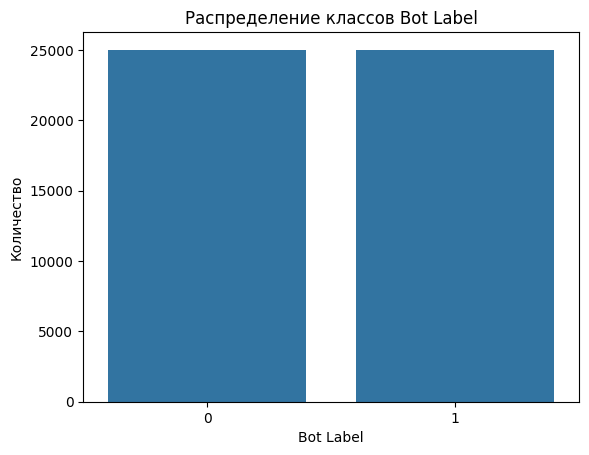

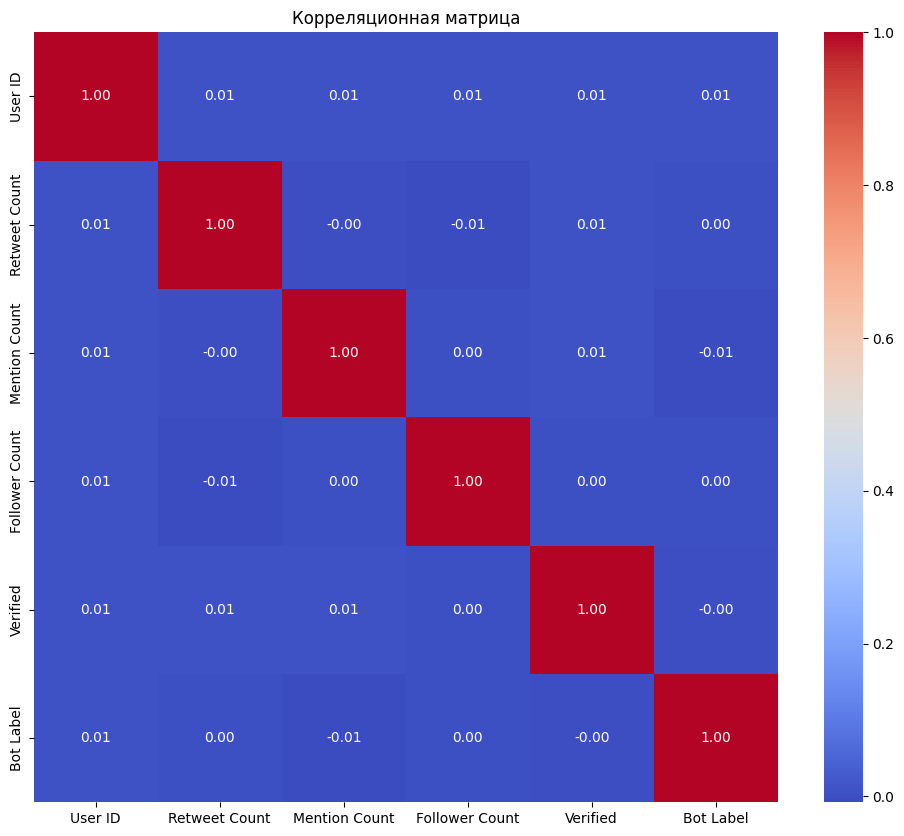

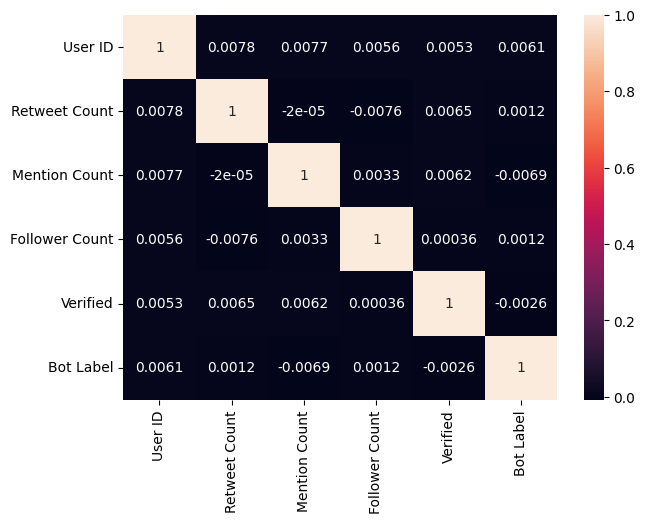


Проверка уникальных значений в 'Hashtags':
[nan 'both live' 'phone ahead' ... 'teach quality ten education any'
 'add walk among believe' 'onto admit artist first']

Статистика по 'Hashtags':
Hashtags
area       21
big        20
treat      19
ground     18
watch      18
black      17
without    16
expert     16
energy     16
chair      16
Name: count, dtype: int64


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv('bot_detection_data.csv')

print("Первые несколько строк датасета:")
print(data.head())


print("\nОбщая информация о датасете:")
print(data.info())


print("\nСтатистические характеристики:")
print(data.describe())


print("\nПроверка на пропущенные значения:")
print(data.isnull().sum())


print("\nРаспределение классов в целевой переменной:")
print(data['Bot Label'].value_counts(normalize=True))


sns.countplot(x='Bot Label', data=data)
plt.title('Распределение классов Bot Label')
plt.xlabel('Bot Label')
plt.ylabel('Количество')
plt.show()

numerical_data = data.select_dtypes(include=['int64', 'float64', 'bool'])

plt.figure(figsize=(12, 10))
correlation_matrix = numerical_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

plt.figure(figsize=(7,5))
sns.heatmap(data.corr(numeric_only = True), annot=True)
plt.show()
                                                  
print("\nПроверка уникальных значений в 'Hashtags':")
print(data['Hashtags'].unique())

print("\nСтатистика по 'Hashtags':")
print(data['Hashtags'].value_counts().head(10))

In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.layers import Layer, LSTM, Bidirectional, Attention, Concatenate, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

data = pd.read_csv('bot_detection_data.csv')

data['Hashtags'].fillna('', inplace=True)
data['Verified'] = data['Verified'].astype(int)

X_text = data['Tweet'].values.tolist()
y = data['Bot Label'].values
retweet_counts = data['Retweet Count'].values
mention_counts = data['Mention Count'].values
follower_counts = data['Follower Count'].values
verified_flags = data['Verified'].values  

X_train_text, X_test_text, y_train, y_test, retweet_counts_train, retweet_counts_test, \
mention_counts_train, mention_counts_test, follower_counts_train, follower_counts_test, verified_flags_train, verified_flags_test = train_test_split(
    X_text, y, retweet_counts, mention_counts, follower_counts, verified_flags, test_size=0.2, random_state=42
)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='tf')

X_train_tokenized = tokenize(X_train_text)
X_test_tokenized = tokenize(X_test_text)

class BertWrapper(Layer):
    def __init__(self):
        super(BertWrapper, self).__init__()
        self.bert = TFBertModel.from_pretrained('bert-base-uncased', return_dict=True)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        return self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

class LSTMWrapper(Layer):
    def __init__(self):
        super(LSTMWrapper, self).__init__()
        self.lstm1 = Bidirectional(LSTM(64, return_sequences=True))
        self.lstm2 = Bidirectional(LSTM(32, return_sequences=False))

    def call(self, inputs):
        x = self.lstm1(inputs)
        return self.lstm2(x)

class ExpandDimsLayer(Layer):
    def call(self, inputs):
        return tf.expand_dims(inputs, axis=1)

class AttentionLayer(Layer):
    def call(self, inputs):
        query = tf.expand_dims(inputs[0], axis=1)
        value = tf.expand_dims(inputs[1], axis=1)
        return Attention()([query, value])

class SqueezeLayer(Layer):
    def call(self, inputs):
        return tf.squeeze(inputs, axis=1)

input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')

bert_output = BertWrapper()([input_ids, attention_mask])
cls_output = bert_output[:, 0, :] 

retweet_count_input = Input(shape=(1,), dtype=tf.float32, name='retweet_count')
mention_count_input = Input(shape=(1,), dtype=tf.float32, name='mention_count')
follower_count_input = Input(shape=(1,), dtype=tf.float32, name='follower_count')
verified_input = Input(shape=(1,), dtype=tf.float32, name='verified')

combined = Concatenate()([cls_output, retweet_count_input, mention_count_input, follower_count_input, verified_input])

expanded_input = ExpandDimsLayer()(combined)
lstm_wrapper = LSTMWrapper()(expanded_input)

attention_output = AttentionLayer()([lstm_wrapper, lstm_wrapper])

attention_output = SqueezeLayer()(attention_output) 

x = Concatenate()([lstm_wrapper, attention_output]) 
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)

output = Dense(1, activation='sigmoid')(x) 

model = tf.keras.Model(inputs=[input_ids, attention_mask, retweet_count_input,
                               mention_count_input, follower_count_input, verified_input], outputs=output)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    {
        'input_ids': X_train_tokenized['input_ids'],
        'attention_mask': X_train_tokenized['attention_mask'],
        'retweet_count': retweet_counts_train,
        'mention_count': mention_counts_train,
        'follower_count': follower_counts_train,
        'verified': verified_flags_train
    },
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(
    {
        'input_ids': X_test_tokenized['input_ids'],
        'attention_mask': X_test_tokenized['attention_mask'],
        'retweet_count': retweet_counts_test,
        'mention_count': mention_counts_test,
        'follower_count': follower_counts_test,
        'verified': verified_flags_test
    },
    y_test
)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

C:\Users\usicc\AppData\Local\Temp\ipykernel_12772\4117261140.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Hashtags'].fillna('', inplace=True)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you

Epoch 1/10


c:\Users\usicc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\usicc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 313s 305ms/step - accuracy: 0.4973 - loss: 0.6950 - val_accuracy: 0.5080 - val_loss: 0.6932
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 299s 299ms/step - accuracy: 0.5004 - loss: 0.6936 - val_accuracy: 0.5080 - val_loss: 0.6932
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 296s 296ms/step - accuracy: 0.4978 - loss: 0.6936 - val_accuracy: 0.5085 - val_loss: 0.6930
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 296s 296ms/step - accuracy: 0.4955 - loss: 0.6934 - val_accuracy: 0.5049 - val_loss: 0.6932
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 295s 296ms/step - accuracy: 0.5004 - loss: 0.6933 - val_accuracy: 0.4920 - val_loss: 0.6932
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 295s 295ms/step - accuracy: 0.4933 - loss: 0.6933 - val_accuracy: 0.4920 - val_loss: 0.6932
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 252ms/step - accuracy: 0.4950 - loss: 0.6934
Test Loss: 0.6934, Test Accuracy: 0.4965
